# Mathematical Finance

This is the example of my code, where I solved tasks using monte carlo simulations.

In [28]:
import numpy as np
import numba as nb
import pandas as pd
from scipy.stats import norm, ncx2
from bsm1 import BSM
from matplotlib import pyplot as plt
import enum 
import scipy.stats as st
import scipy.optimize as optimize
from tqdm import tqdm

## Monte Carlo

### Problem 1: Hitting time (15 points)

In the lecture we derived the probability to hit the barrier.

Realize Monte-Carlo to calculate this probability numerically to validate the analytical formula.

Use the following parameters:

$S_0=100, B=130, \sigma = 45\%, T=1, r=2\%$.


a) Realize Euler method for the _time discretization_. Calculate MC error for the following cases of $m = 100, 250, 500, 750, 1000$. Plot results.

b) Do the same for Milstein method. Does it improve MS estimates?

Use 100K MC simulations ($n=100,000$).



c) Realize AV variance reduction with Euler method and $m = 500$. Compare the MC error with corresponding calculations in a) point. To calculate the MC error for this case, sample the MC estimator 12-25 times and compute the sample standard deviation.


### Solution

First, let's recall the analytical formula and find the analytical solution for this example:

$$P(T_H ≤T) = \left(\frac{B}{S_0} \right)^{(\frac{2r}{σ^2}-1 )}N(d) +N(d_{-})$$

where $d = \frac{\ln S/B-(r-\sigma^2/2)T}{\sigma \sqrt{T}}$ and $d_{-} = \frac{\ln S/B+(r-\sigma^2/2)T}{\sigma \sqrt{T}}$

So, in our example, we get that $d = \frac{\ln 100/130-(0.02-0.45^2/2)\times 1}{0.45 \times 1}$ and $d_{-} = \frac{\ln 100/130+(0.02-0.45^2/2)\times 1}{0.45 \times 1}$



In [29]:
dp = (np.log(100/130)-(0.02-0.45**2 / 2))/0.45
dm = (np.log(100/130)+(0.02-0.45**2 / 2))/0.45

print(f"d plus is {dp:0.2f}")
print(f"d minus is {dm:0.2f}\n")

print(f"N(d) = {norm.cdf(dp):.2f}")
print(f"N(d minus) = {norm.cdf(dm):.2f}\n")

P = (130 / 100)**(2*0.02/0.45**2-1)*norm.cdf(dp) + norm.cdf(dm)

print(f"Probability of hitting the barrier analytically is {P:.4f}")

d plus is -0.40
d minus is -0.76

N(d) = 0.34
N(d minus) = 0.22

Probability of hitting the barrier analytically is 0.5010


__Task A__

In [31]:
@nb.njit()
def task_a(T, S, r, vol, B, m):
    dt = T / m
    paths = []

    for p in range(100_000):
        s_path = [S]
        st = S
        for i in range(m):
            st += r * st * dt + np.random.normal(0, vol * st * dt**0.5)
            s_path.append(st)
        paths.append(np.array(s_path))
    
    return np.array([(i >= B).any() for i in paths]).mean(), paths

p_mc_a, paths = task_a(data['T'], data['S'], data['r'], data['vol'], data['B'], m=100)
print(f"For m = 100, MC estimation using Euler method is {p_mc_a:.2f}")

p_mc_a = [task_a(data['T'], data['S'], data['r'], data['vol'], data['B'], m=m)[0] for m in [100, 250, 500, 750, 1000]]

For m = 100, MC estimation using Euler method is 0.46


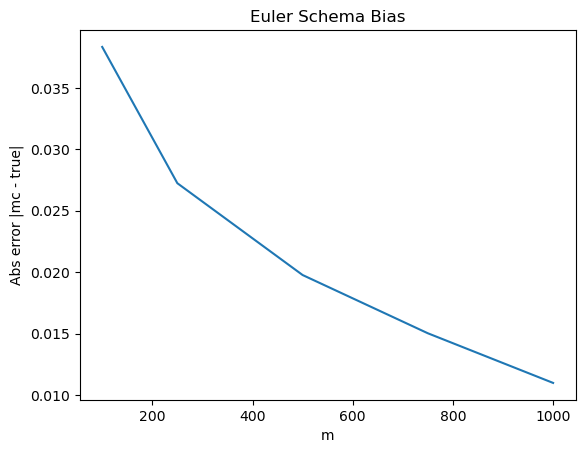

In [32]:
plt.plot([100, 250, 500, 750, 1000], abs(P - np.array(p_mc_a)))
plt.xlabel('m')
plt.ylabel('Abs error |mc - true|')
plt.title('Euler Schema Bias')
plt.show()

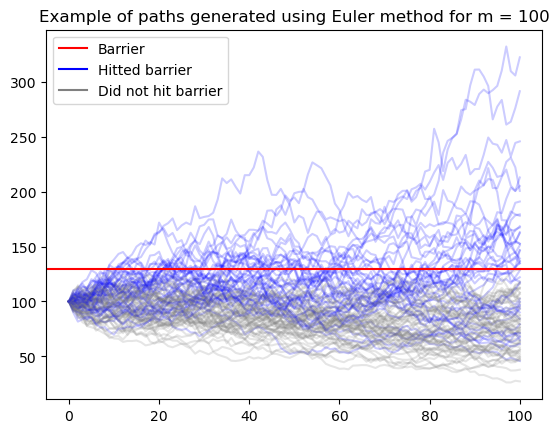

In [33]:
np.random.seed(42)
sample = np.random.choice(range(len(paths)), 100)
for i in sample:
    if (paths[i] >= data['B']).any():
        c = 'blue'
    else:
        c = 'gray'
    plt.plot(paths[i], c=c, alpha=0.2)
plt.axhline(y=data['B'], color='r', linestyle='-', label='Barrier')
plt.plot([], [], c='b', label="Hitted barrier")
plt.plot([], [], c='gray', label="Did not hit barrier")
plt.legend()
plt.title('Example of paths generated using Euler method for m = 100')
plt.show()

__Task B__

In [34]:
@nb.njit()
def task_b(T, S, r, vol, B, m):
    dt = T / m
    paths = []

    for p in range(100_000):
        s_path = [S]
        st = S
        for i in range(m):
            eps = np.random.normal(0, 1)
            st += r * st * dt + vol * st * dt**0.5 * eps + 0.5 * vol * vol * st * dt * (eps**2 - 1)
            s_path.append(st)
        paths.append(np.array(s_path))
    
    return np.array([(i >= B).any() for i in paths]).mean(), paths

In [35]:
p_mc_b, paths = task_b(data['T'], data['S'], data['r'], data['vol'], data['B'], m=100)
print(f"For m = 100, MC estimation using Milstein method is {p_mc_b:.2f}")

p_mc_b = [task_b(data['T'], data['S'], data['r'], data['vol'], data['B'], m=m)[0] for m in [100, 250, 500, 750, 1000]]

For m = 100, MC estimation using Milstein method is 0.46


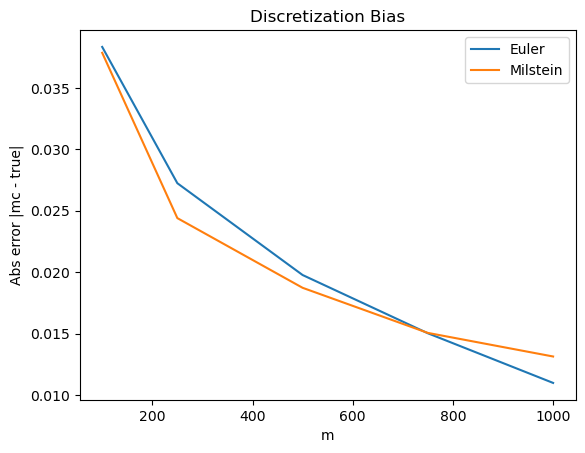

In [36]:
plt.plot([100, 250, 500, 750, 1000], abs(P - np.array(p_mc_a)), label='Euler')
plt.plot([100, 250, 500, 750, 1000], abs(P - np.array(p_mc_b)), label='Milstein')
plt.xlabel('m')
plt.ylabel('Abs error |mc - true|')
plt.title('Discretization Bias')
plt.legend()
plt.show()

We see that the Milstein method did not improve the error.

__Task C__

In [37]:
# C

@nb.njit()
def task_c(T, S, r, vol, B, m):
    dt = T / m
    paths = []

    for p in range(100_000):
        s_path_1 = [S]
        s_path_2 = [S]
        st_1 = S
        st_2 = S
        
        for i in range(m):
            eps = np.random.normal(0, 1)
            st_1 += r * st_1 * dt + vol * st_1 * dt**0.5 * eps
            s_path_1.append(st_1)
            st_2 += r * st_2 * dt - vol * st_2 * dt**0.5 * eps
            s_path_2.append(st_2)
        paths.append(np.array(s_path_1))
        paths.append(np.array(s_path_2))
    return np.array([(i >= B).any() for i in paths]).mean()

In [38]:
p_mc_c = task_c(data['T'], data['S'], data['r'], data['vol'], data['B'], m=500)
print(f"For m = 500, MC estimation using AV reduction method is {p_mc_c:.2f}")

For m = 500, MC estimation using AV reduction method is 0.48


In [39]:
std_c = np.std([task_c(data['T'], data['S'], data['r'], data['vol'], data['B'], m=500) for _ in range(25)])
std_a = np.std([task_a(data['T'], data['S'], data['r'], data['vol'], data['B'], m=500)[0] for _ in range(25)])

In [40]:
print(f'Standard (statistical) error in A is {std_a:.4f}')
print(f'Standard (statistical) error in C is {std_c:.4f}')

Standard (statistical) error in A is 0.0011
Standard (statistical) error in C is 0.0007


We see an improvement in accuracy in (C), i.e. when using antithetic variance reduction, compared to the case in (A), i.e. when we did not apply any variance reduction technique. It is not surprising because paths have negative covarience, hence, the variance of the sample paths is reduced.

<br>

### Problem 2: (10 points)

In Hw1 Problem 5 you derived to price of digital Quanto.

Realize Monte-Carlo to calculate it numerically.

__MC should be realize in USD measure__, so the payoff is $\frac{NX_0  1_{Y_T > K}}{X_T}$ USD at time $T$

Note, the analytical formula was calculated in RUB measure.

Use 1 mln MC simulations. Calculate MC error, and 95% confidence interval (CE).
Is an analytical result located inside this CE?


__Recall__

Let's recall the task:

Quanto forward contract pays $NX_0  1_{Y_T > K}$ RUB at time $T$, where $Y_t$ and 

$X_t$ is the USD/RUB exchange rate.

 $dX = (r_{RUB}-r_{USD})Xdt + \sigma_{X} X dW^1$ 

in RUB-measure (risk neutral world, where RUB money market account is numeraire).


$Y_t$ is the oil future price (expressed in USD). <br/>

It follows $dY =  \sigma_{Y} Y dW^2$ in USD-measure (risk neutral world, where USD money market account is numeraire).

Assume, $dW^1 dW^2 = \rho dt$.

### Solution

It is evident that in USD-measure:

$d\big(\frac{1}{X}\big) = (r_{usd} - r_{rub})\big(\frac{1}{X}\big)dt - \sigma_X \big(\frac{1}{X}\big)d\tilde W^1$

And so: $dW^1 = \tilde{dW^1 }= dB^1$ and $dW^2 = \rho dB^1 + \sqrt{1 - \rho^2}dB^2$

Let $Y_0 = 100; X_0 = 1; K = 130; \sigma_Y = 0.3; \sigma_X = 0.45; \rho = 0.2; r_{rub}=0.05; r_{usd} = 0.02; N = 2; T = 1$.



In [41]:
data = {
    'T': 1,
    'N': 2,
    'K': 100,
    'Y0': 140,
    'X0': 2,
    'vol_y': 0.3,
    'vol_x': 0.45,
    'rho': 0.2,
    'r_rub': 0.05,
    'r_usd': 0.02,
}

@nb.njit()
def mc(T, N, K, Y0, X0, vol_y, vol_x, rho, r_rub, r_usd):

    res = []

    for _ in range(1_000_000):
        yt = Y0
        xt = 1 / X0
        b1, b2 = np.random.normal(0, 1), np.random.normal(0, 1)
        w1, w2 = rho * b1, (1-rho**2)**0.5 * b2
        yt += vol_y * yt * T**0.5 * w2
        xt += (r_usd - r_rub) * xt * T - vol_x * xt * T**0.5 * w1
        
        if yt > K:
            res.append(N * X0 * xt)
        else:
            res.append(0)
            
    res = np.array(res)
            
    return res.mean() * np.exp(-r_usd * T) * X0

In [42]:
mc_est = mc(**data)

# print(f'USD price {mc_est / X0:.2f}')
print(f'RUB price {mc_est:.3f}')

print(f'Std of mc is {(std:=np.std([mc(**data) for _ in range(25)])):.3f}')
print(f'CI (95%) is ({(mc_est - 1.96 * std):.3f}, {(mc_est + 1.96 * std):.3f})')


RUB price 3.173
Std of mc is 0.001
CI (95%) is (3.171, 3.175)


__Analytical Formula__

The price of this Quanto in RUB is $e^{−r_{RUB} T} NX_0  \Phi (\frac{-\ln K + \ln Y_0 + \big(-\rho \sigma_X \sigma_Y - 0.5\sigma_{Y}^2\big)T}{\sigma_Y \sqrt{T}})$ (our solution)


(Vyacheslav's solution)

$\epsilon > \frac{\ln K_T/Y_0 - σ_{Y}(\rho σ_{x}-σ_{Y}/2)T}{\sigma \sqrt{T}} = d$

Finally, $D_0 = e^{-r_{RUB}T}N X_0 N(d)$

In [43]:
def digital_quanto(T, N, K, Y0, X0, vol_y, vol_x, rho, r_rub, r_usd):
    d = (np.log(Y0 / K) + (-rho * vol_x * vol_y - 0.5 * vol_y**2) * T) / (vol_y * np.sqrt(T))
    return np.exp(-r_rub * T) * N * X0 * norm.cdf(d)

print(f'Analytical price is {digital_quanto(**data):.3f}')

Analytical price is 3.086


### Problem 3: CEV model (17 points)

a) (10 points) Realize option pricer for CEV model using closed-form solution (can be found in Hull).

Check the pricer using MC simulation (via Euler approximation) for one option at your choice.



### Solution

In [44]:
def cev_analytic(S, r, q, K, alpha, vol, T, type='call'):
    assert type in ('call', 'put'), 'Type must be "call" or "put"'
    assert alpha > 0, 'Alpha must be greater than 0'
    assert alpha != 1, 'Alpha must be different from 1'
    
    v = vol**2 / (2*(r-q)*(alpha - 1)) * (np.exp(2*(r-q)*(alpha-1)*T) - 1)
    a = ((K * np.exp(-(r-q)*T))**(2*(1-alpha))) / ((1-alpha)**2 * v)
    b = 1 / (1-alpha)
    c = (S**(2*(1-alpha))) / ((1-alpha)**2 * v)
    
    if alpha < 1:
        if type == 'call':
            price = S * np.exp(-q*T)*(1-ncx2.cdf(a, b+2, c)) - K *np.exp(-r*T) * ncx2.cdf(c, b, a)
        if type == 'put':
            price = K * np.exp(-r*T)*(1-ncx2.cdf(c, b, a)) - S *np.exp(-q*T) * ncx2.cdf(a, b + 2, c)
    if alpha > 1:
        if type == 'call':
            price = S * np.exp(-q*T)*(1-ncx2.cdf(c, -b, a)) - K *np.exp(-r*T) * ncx2.cdf(a, 2 - b, c)
        if type == 'put':
            price = K * np.exp(-r*T)*(1-ncx2.cdf(a, 2 - b, c)) - S *np.exp(-q*T) * ncx2.cdf(c, -b, a)
    
    return price

In [45]:
data = {'S': 10, 'r': 0.04, 'q': 0.01, 'K': 11, 'alpha': 1.4, 'vol': 0.2, 'T': 1, 'type': 'put'}
cev_analytic(**data)

2.421875715576731

In [46]:
@nb.njit()
def cev_mc(S, r, q, K, alpha, vol, T, type='call', m=1000):
    assert type in ('call', 'put'), 'Type must be "call" or "put"'
    assert alpha > 0, 'Alpha must be greater than 0'
    assert alpha != 1, 'Alpha must be different from 1'
    
    dt = T / m
    res = []

    for p in range(1_000):
        st = S
        for i in range(m):
            eps = np.random.normal(0, 1)
            st += (r - q) * st * dt + vol * st**alpha * dt**0.5 * eps
        if type == 'call':
            res.append(np.array([st - K, 0.0]).max())
        if type == 'put':
            res.append(np.array([K - st, 0.0]).max())
    
    return np.array(res).mean()

cev_mc(**data)

2.5230725394092355

<br>
b) (7 points)

Consider of SP500 options as of Mar 25 2024 maturing Apr 1 2024.

Data can be found attached.

 Plot IV curve. Use the strike range = $[4,000; 5,600]$.

 Calibrate the model to this curve (find $\beta$ and $\sigma$) by fitting the model curve to the market one.


### Solution

In [47]:
path = ""
data = pd.read_csv(path + 'dataOptions - dataOptions.csv')
data = data.query('Strike != "Strike"')

data['Strike'] = data['Strike'].str.replace(',', '')
data['Strike'] = data['Strike'].astype(float)

data['Implied Volatility'] = data['Implied Volatility'].str.replace('%', '')
data['Implied Volatility'] = data['Implied Volatility'].astype(float)
data['Implied Volatility'] /= 100

data['Last Trade Date'] = pd.to_datetime(data['Last Trade Date'].str[:-4], format='%Y-%m-%d  %I:%M%p')

data = data[data['Last Trade Date'].dt.date.astype(str) == '2024-03-25']
data = data.query('4000 < Strike < 5600').sort_values(by='Strike')

data['Type'] = data.eval('`Contract Name`.str.contains("C")').replace({True: 'call', False: 'put'})

data

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,Type
348,SPXW240430P04050000,2024-03-25 03:41:00,4050.0,1.55,1.2,1.3,0,-,82,0,0.3356,put
350,SPXW240430P04070000,2024-03-25 06:02:00,4070.0,1.6,1.25,1.35,0,-,35,0,0.3314,put
353,SPXW240430P04090000,2024-03-25 08:38:00,4090.0,1.66,1.3,1.4,0,-,38,0,0.3270,put
354,SPXW240430P04100000,2024-03-25 14:32:00,4100.0,1.5,1.3,1.4,0,-,15,0,0.3240,put
355,SPXW240430P04110000,2024-03-25 06:02:00,4110.0,1.7,1.35,1.45,0,-,35,0,0.3225,put
...,...,...,...,...,...,...,...,...,...,...,...,...
585,SPXW240430P05450000,2024-03-25 09:37:00,5450.0,211.08,196.9,201.4,0,-,1,0,0.0000,put
237,SPXW240430C05450000,2024-03-25 16:14:00,5450.0,9.3,11,11.2,0,-,78,0,0.1164,call
240,SPXW240430C05475000,2024-03-25 15:44:00,5475.0,7.46,8.1,8.4,0,-,1,0,0.1156,call
243,SPXW240430C05500000,2024-03-25 15:20:00,5500.0,5.5,5.9,6.1,0,-,5,0,0.1143,call


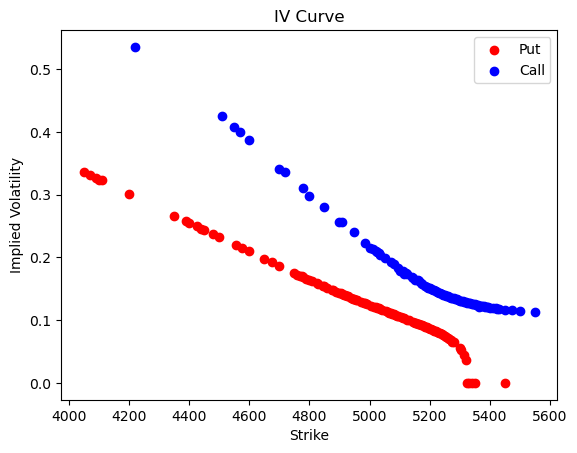

In [48]:
X_put, y_put = data.query("Type == 'put'")['Strike'], data.query("Type == 'put'")['Implied Volatility']
X_call, y_call = data.query("Type == 'call'")['Strike'], data.query("Type == 'call'")['Implied Volatility']
plt.scatter(X_put, y_put, c='r', label="Put")
plt.scatter(X_call, y_call, c='b', label="Call")
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('IV Curve')
plt.legend()
plt.plot()
plt.show()

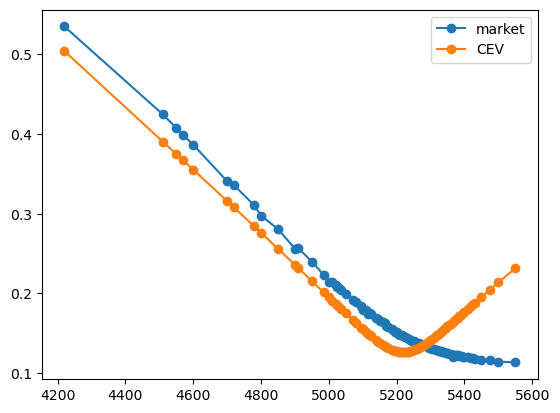

In [49]:
"""
@https://quant.stackexchange.com/questions/57786/sabr-model-pricing-engine-in-python-quantli
"""

import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

strikes = X_call
fwd = 5218
expiryTime = 25/252
marketVols = y_call

params = [0.1] * 4
def f(params):
    vols = np.array([
        ql.sabrVolatility(strike, fwd, expiryTime, *params)
        for strike in strikes
    ])
    return ((vols - np.array(marketVols))**2 ).mean() **.5

cons=(
    {'type': 'ineq', 'fun': lambda x:  0.95 - x[1]},
    {'type': 'ineq', 'fun': lambda x: x[1]},      
    {'type': 'ineq', 'fun': lambda x: x[3]}
)

result = minimize(f, params, constraints=cons)
new_params = result['x']

newVols = [ql.sabrVolatility(strike, fwd, expiryTime, *new_params) for strike in strikes]
plt.plot(strikes, marketVols, marker='o', label="market")
plt.plot(strikes, newVols, marker='o', label="CEV")
plt.legend();

In [50]:
print(f'beta {result.x[1]:.2f}')
print(f'vol {result.x[2]:.2f}')

beta 0.73
vol 5.93


### Problem 4: Local volality model (5 points)

Integrating by parts two times calculate the value of the integral:

$\int_{K}^{\infty}(S-K)(-(rSp)_S + \frac{1}{2}(\sigma^2 S^2 p)_{SS})dS$





### Solution

Open the brackets: $\int_{K}^{\infty}(S-K)(-(rSp)_S + \frac{1}{2}(\sigma^2 S^2 p)_{SS})dS = -\int_{K}^{\infty} (S-K)(rSp)_S dS + \frac{1}{2}\int_{K}^{\infty}(S-K)(\sigma^2 S^2 p)_{SS} dS$



_1. Consider the first term_: $-r \int_{K}^{\infty} (S-K)(Sp)_S dS$

Let $u = S-K$ and $v_S = (Sp)_S$, then $u_S = 1$ and $v = Sp$

$-r \int_{K}^{\infty} (S-K)(Sp)_S dS = -r (S-K) Sp \Big|_K^{\infty} + r \int_{K}^{\infty} Sp dS = -0 + 0 + r\int_{K}^{\infty}SpdS$

Note, that $-r (S-K) Sp \Big|_K^{\infty} = 0$ comes from the assumption that $ \lim_{S \to \infty} p = 0 \Longrightarrow \lim_{S \to \infty} (S-K) Sp  = 0 $

_2. Consider the second term_: $\frac{1}{2}\int_{K}^{\infty}(S-K)(\sigma^2 S^2 p)_{SS} dS$


Let $u = S-K$ and $v_S = (\sigma^2 S^2p)_{SS}$, then $u_S = 1$ and $v = (\sigma^2 S^2p)_S$ respectively.

Thus, $\frac{1}{2}\int_{K}^{\infty}(S-K)(\sigma^2 S^2 p)_{SS} dS = \frac{1}{2}(S-K) (\sigma^2 S^2p) \Big|_K^{\infty} - \frac{1}{2}\int_K^{\infty} (\sigma^2 S^2p)_S = 0 - \frac{1}{2}\sigma^2 S^2p \Big|_K^{\infty} =\frac{1}{2}\sigma^2 S^2p $


Putting together,
$$\int_{K}^{\infty}(S-K)(-(rSp)_S + \frac{1}{2}(\sigma^2 S^2 p)_{SS})dS  = r\int_{K}^{\infty}SpdS + \frac{1}{2}\sigma^2 S^2p$$



Note, that we can further get rid of the integral using the formula for call option price: $C = \exp (- \int_t^Tr_s ds) \int_K^{\infty}(S-K)pdS$

Omit $\exp (- \int_t^Tr_s ds) = Z(t, T)$ – a discount factor for convenience, then $C = \int_{K}^{\infty}SpdS - K \int_K^{\infty}pdS$ where the first term is exactly our unsolved integral $\int_{K}^{\infty}SpdS$.

$C_K = \int_K^{\infty}pdS \Longrightarrow \int_K^{\infty}SpdS = C-K \cdot C_K$

Therefore, we now can rewrite $\int_{K}^{\infty}SpdS$ as: 
$C - KC_K$

Also, $C_{KK} = -p \Big|_K^{\infty} = p$

Finally, we can rewrite our result as: 

$$\int_{K}^{\infty}(S-K)(-(rSp)_S + \frac{1}{2}(\sigma^2 S^2 p)_{SS})dS = \frac{1}{Z} (rC + rKC_K + \frac{1}{2}\sigma^2S^2C_{KK}) $$